<a href="https://colab.research.google.com/github/swilsonmfc/imbalanced/blob/main/CostSensitiveLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cost-Based Learning

# Install

In [1]:
!pip install imblearn

In [2]:
!pip install imbalance-xgboost

# Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils.multiclass import unique_labels

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from imblearn.pipeline import make_pipeline
from imblearn.base import BaseSampler
from imblearn.metrics import classification_report_imbalanced

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [4]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Dataset

In [5]:
def create_dataset(n_samples=1000, weights=(0.02, 0.98), n_classes=2, class_sep=0.8, n_clusters=1):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, 
                               random_state=0)

# Helpers

## Plots

In [6]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    
def plot_comparison(sampler, X, y):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

    pipe = make_pipeline(LinearSVC())
    pipe.fit(X, y)
    plot_decision_function(X, y, pipe, ax1)
    ax1.set_title('Linear SVC with y={}'.format(Counter(y)))

    plot_resampling(X, y, sampler, ax2)
    ax2.set_title('Resampling using {}'.format(type(sampler).__name__))
    fig.tight_layout()

    pipe = make_pipeline(sampler, LinearSVC())
    pipe.fit(X, y)
    plot_decision_function(X, y, pipe, ax3)
    ax3.set_title('Decision function for {}'.format(type(sampler).__name__))
    
    return pipe

## ROC

In [7]:
def plot_roc(classifier, y, y_hat, probs):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
 
  #Imbalanced ROC Curve
  fpr, tpr, thresholds = roc_curve(y, probs)
  auc_roc = roc_auc_score(y, probs)
  ax1.plot([0, 1], [0, 1], linestyle='--')
  ax1.plot(fpr, tpr, marker='.')
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  ax1.set_title('ROC Curve - AUC: %.3f' % auc_roc)

  #Precision Recall Curve
  precision, recall, thresholds = precision_recall_curve(y, probs)
  auc_pre_rec = auc(recall, precision)
  no_skill = sum(y) / len(y)
  ax2.plot([0, 1], [no_skill, no_skill], linestyle='--')
  ax2.plot(recall, precision, marker='.')
  ax2.set_xlabel('Recall')
  ax2.set_ylabel('Precision')
  ax2.set_title('Precision Recall Curve - AUC: %.3f' % auc_pre_rec)

  return auc_roc, auc_pre_rec

## Confusion

In [8]:
def confusion(technique, y_hat, y):
    cm = confusion_matrix(y, y_hat)
    class_report = classification_report_imbalanced(y, y_hat)
    maj_precision = cm[0][0] / (cm[0][0] + cm[1][0])
    maj_recall    = cm[0][0] / (cm[0][0] + cm[0][1])
    min_precision = cm[1][1] / (cm[1][1] + cm[0][1])
    min_recall    = cm[1][1] / (cm[1][1] + cm[1][0])

    plt.figure(figsize=(15,7))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Majority', 'Minority'])
    ax.yaxis.set_ticklabels(['Majority', 'Minority'])

    print(class_report)
    return cm, class_report, (maj_precision, maj_recall), (min_precision, min_recall)

# Tracking

In [9]:
# Keep a summary of how well different techniques work
cols = pd.MultiIndex.from_tuples(zip(['Majority', 'Majority', 'Minority', 'Minority', 'AUC', 'AUC'],
                                     ['Precision', 'Recall', 'Precision', 'Recall', 'ROC', 'Precision/Recall']))

results_df = pd.DataFrame(columns=cols)

In [10]:
results_df

Empty DataFrame
Columns: [(Majority, Precision), (Majority, Recall), (Minority, Precision), (Minority, Recall), (AUC, ROC), (AUC, Precision/Recall)]
Index: []

# Test Train

In [11]:
X, y = create_dataset(n_samples=1000, weights=(0.95, 0.05), class_sep=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

print(f'Train Shape : {X_train.shape}')
print(f'Test  Shape : {X_test.shape}')
print(f'Minority in Train: {y_train.sum()}')
print(f'Minority in Test : {y_test.sum()}')

Train Shape : (750, 2)
Test  Shape : (250, 2)
Minority in Train: 39
Minority in Test : 17


## Data Scatter

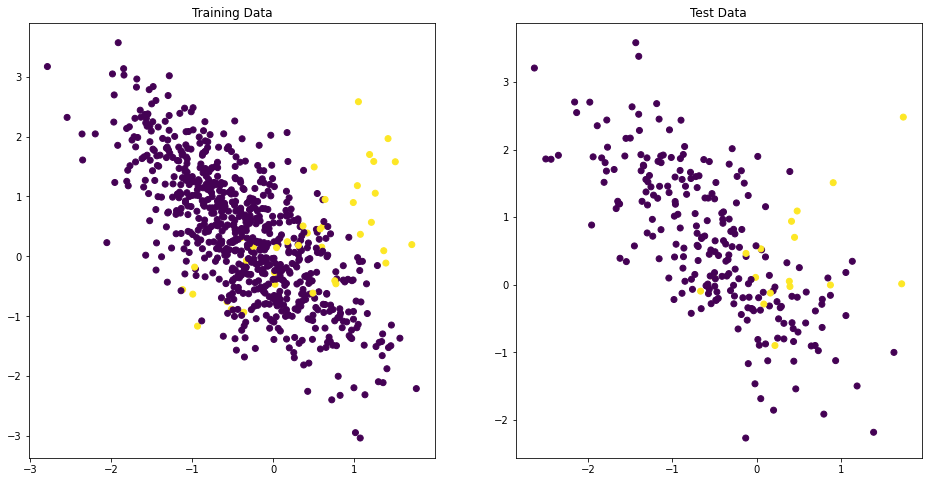

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
ax1.set_title('Training Data')

ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
ax2.set_title('Test Data');

# RandomForest

## Unweighted

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.99      0.18      0.97      0.42      0.19       233
          1       0.60      0.18      0.99      0.27      0.42      0.16        17

avg / total       0.92      0.94      0.23      0.92      0.42      0.19       250



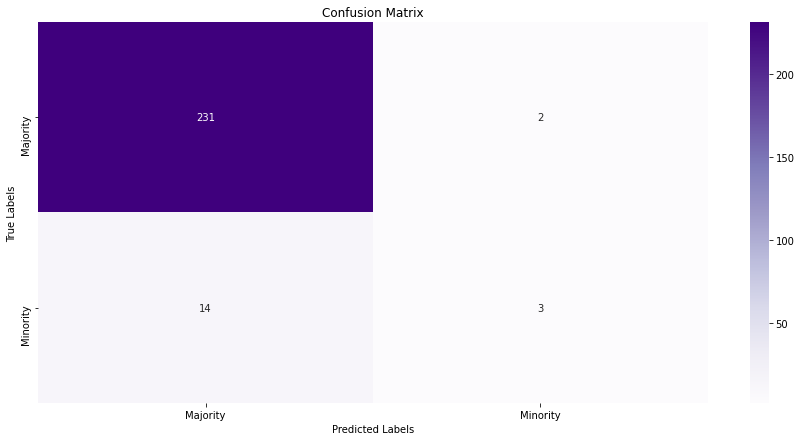

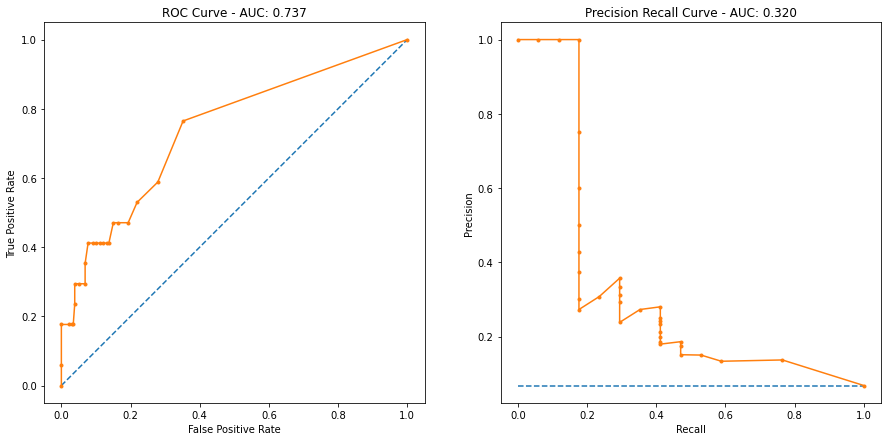

In [13]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_hat = classifier.predict(X_test)
probs = classifier.predict_proba(X_test)
con, cr, majority, minority = confusion('RandomForest', y_hat, y_test)
auc_rec, auc_pre_rec = plot_roc(classifier, y_test, y_hat, probs[:, 1])

In [14]:
results_df.loc['RandomForest'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            Minority                 AUC                 
             Precision    Recall Precision    Recall       ROC Precision/Recall
RandomForest  0.942857  0.991416       0.6  0.176471  0.737314          0.32025

## Balanced
Places a weighting on the each example.  The algorithm needs to minimize the weighted loss.

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.99      0.18      0.97      0.42      0.19       233
          1       0.60      0.18      0.99      0.27      0.42      0.16        17

avg / total       0.92      0.94      0.23      0.92      0.42      0.19       250



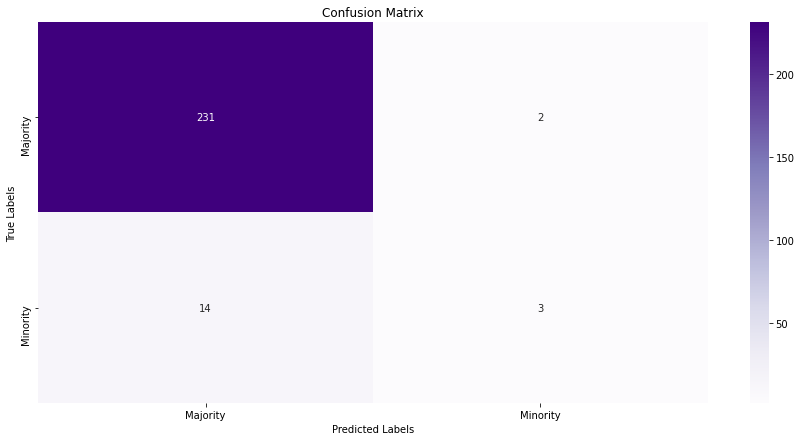

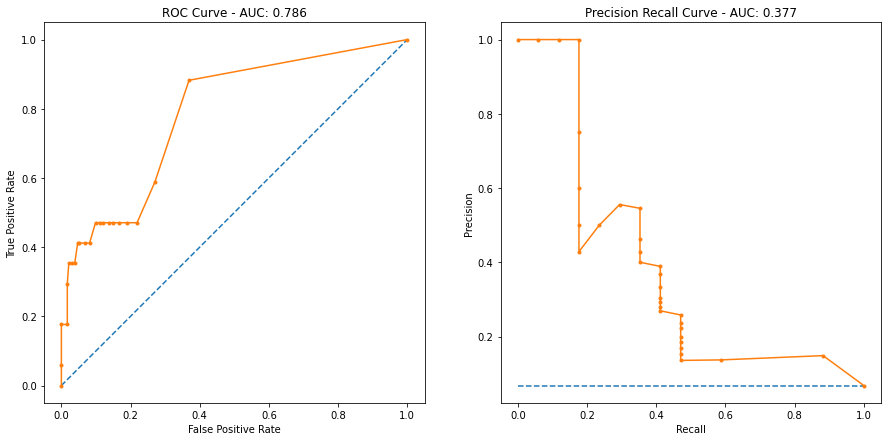

In [15]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_hat = classifier.predict(X_test)
probs = classifier.predict_proba(X_test)
con, cr, majority, minority = confusion('BalancedRandomForest', y_hat, y_test)
auc_rec, auc_pre_rec = plot_roc(classifier, y_test, y_hat, probs[:, 1])

In [16]:
results_df.loc['BalancedRandomForest'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
RandomForest          0.942857  0.991416  ...  0.737314         0.320250
BalancedRandomForest  0.942857  0.991416  ...  0.785660         0.376677

[2 rows x 6 columns]

## Weighted
* Directly set weights of minority class
* There is a limit here.  
  * We put the weights on minority observations in the training dataset.  
  * That may not always generalize to the test dataset.

In [17]:
ratio = (len(y_test) - sum(y_test)) // sum(y_test)
weights = {0:1,
           1:10 * ratio}
print(f'Ratio     : {ratio}')
print(f'Weighting : {weights}')

Ratio     : 13
Weighting : {0: 1, 1: 130}


                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.99      0.12      0.96      0.34      0.13       233
          1       0.50      0.12      0.99      0.19      0.34      0.11        17

avg / total       0.91      0.93      0.18      0.91      0.34      0.13       250



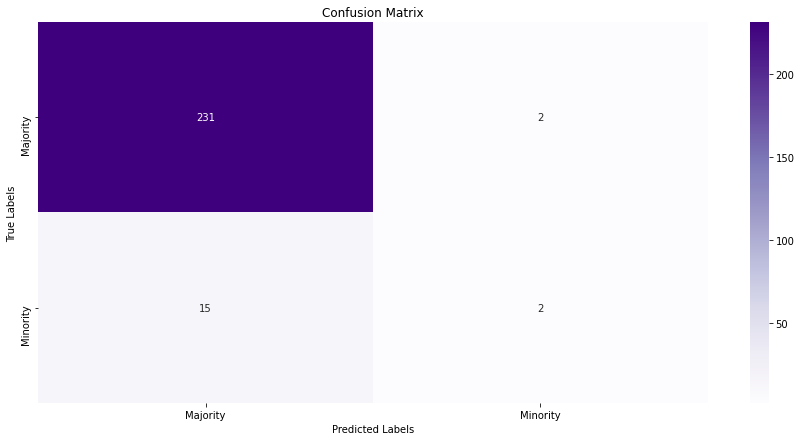

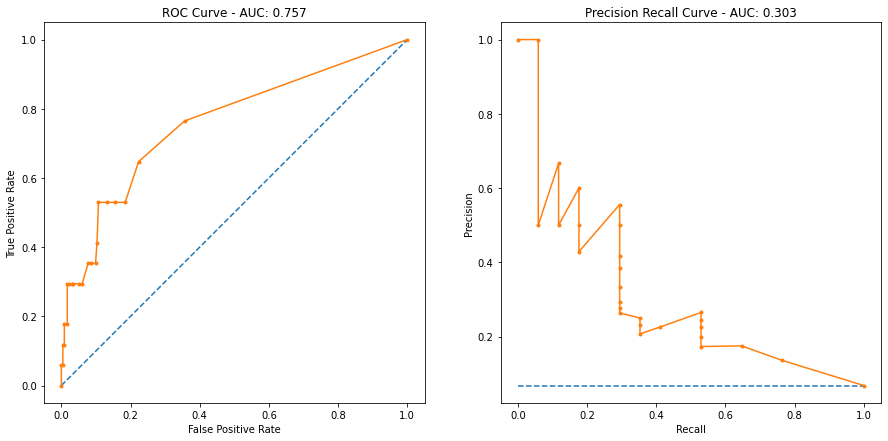

In [18]:
classifier = RandomForestClassifier(class_weight=weights)
classifier.fit(X_train, y_train)
y_hat = classifier.predict(X_test)
probs = classifier.predict_proba(X_test)
con, cr, majority, minority = confusion('WeightedRandomForest', y_hat, y_test)
auc_rec, auc_pre_rec = plot_roc(classifier, y_test, y_hat, probs[:, 1])

In [19]:
results_df.loc['WeightedRandomForest'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
RandomForest          0.942857  0.991416  ...  0.737314         0.320250
BalancedRandomForest  0.942857  0.991416  ...  0.785660         0.376677
WeightedRandomForest  0.939024  0.991416  ...  0.757258         0.302673

[3 rows x 6 columns]

# XGBoost

## Unweighted

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.99      0.12      0.96      0.34      0.13       233
          1       0.50      0.12      0.99      0.19      0.34      0.11        17

avg / total       0.91      0.93      0.18      0.91      0.34      0.13       250



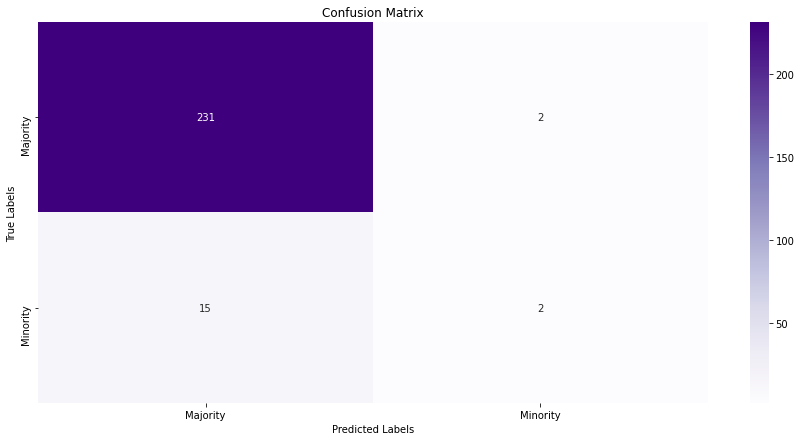

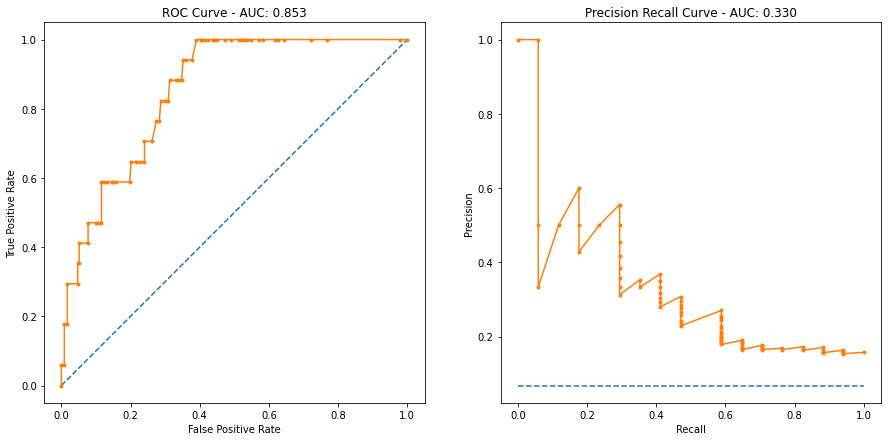

In [20]:
classifier = xgb.XGBClassifier()
classifier.fit(X_train, y_train)
y_hat = classifier.predict(X_test)
probs = classifier.predict_proba(X_test)
con, cr, majority, minority = confusion('XGBoost', y_hat, y_test)
auc_rec, auc_pre_rec = plot_roc(classifier, y_test, y_hat, probs[:, 1])

In [21]:
results_df.loc['XGBoost'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
RandomForest          0.942857  0.991416  ...  0.737314         0.320250
BalancedRandomForest  0.942857  0.991416  ...  0.785660         0.376677
WeightedRandomForest  0.939024  0.991416  ...  0.757258         0.302673
XGBoost               0.939024  0.991416  ...  0.853067         0.329810

[4 rows x 6 columns]

## Weighted

In [22]:
ratio = (len(y_test) - sum(y_test)) // sum(y_test)
print(f'Ratio : {ratio}')

Ratio : 13


                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.95      0.18      0.95      0.41      0.18       233
          1       0.21      0.18      0.95      0.19      0.41      0.16        17

avg / total       0.89      0.90      0.23      0.90      0.41      0.18       250



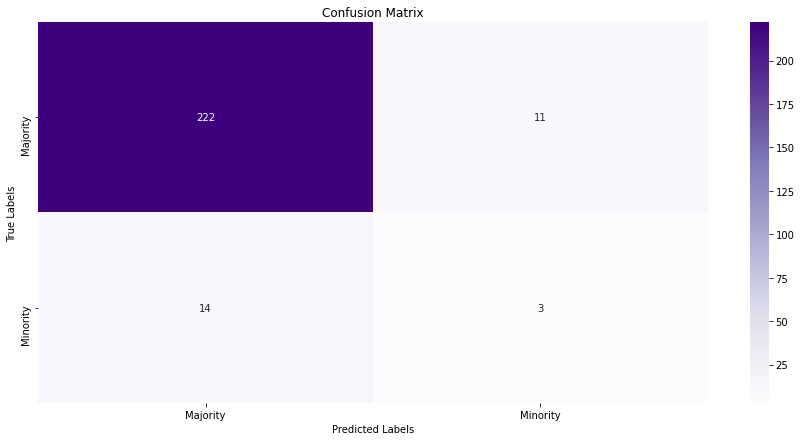

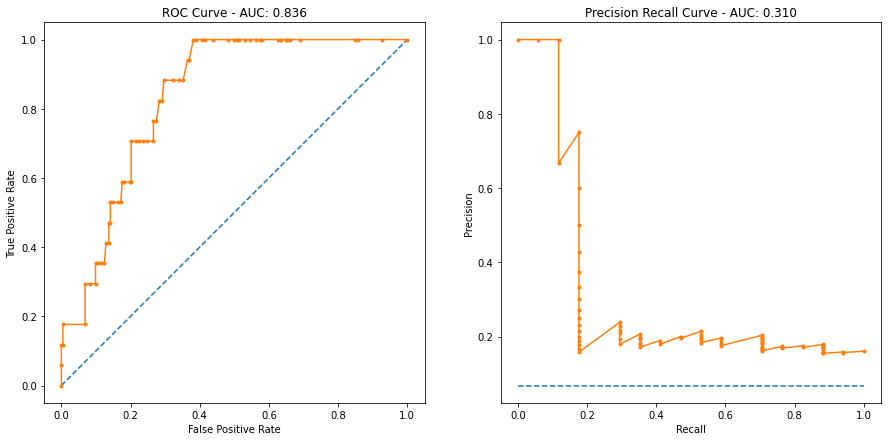

In [23]:
classifier = xgb.XGBClassifier(scale_pos_weight=ratio)
classifier.fit(X_train, y_train)
y_hat = classifier.predict(X_test)
probs = classifier.predict_proba(X_test)
con, cr, majority, minority = confusion('XGBoost', y_hat, y_test)
auc_rec, auc_pre_rec = plot_roc(classifier, y_test, y_hat, probs[:, 1])

In [24]:
results_df.loc['WeightedXGBoost'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
RandomForest          0.942857  0.991416  ...  0.737314         0.320250
BalancedRandomForest  0.942857  0.991416  ...  0.785660         0.376677
WeightedRandomForest  0.939024  0.991416  ...  0.757258         0.302673
XGBoost               0.939024  0.991416  ...  0.853067         0.329810
WeightedXGBoost       0.940678  0.952790  ...  0.835521         0.309999

[5 rows x 6 columns]

# Focal Loss
* Address the issue of the class imbalance problem with a custom loss function
* Adjusts the Cross-Entropy loss function
* Makes it efficient and easy to learn on hard examples
  * False Negatives are considered hard
  * True Negatives are considered easy
* https://medium.com/visionwizard/understanding-focal-loss-a-quick-read-b914422913e7 

## Cross-Entropy

![](https://miro.medium.com/max/315/1*dO6YVNrn8kZI2tFl_-KRZg.png)

![](https://miro.medium.com/max/339/1*HuDkBQFJC3SPAHbr_5fe5A.png)

## Focal Loss

![](https://miro.medium.com/max/262/1*kJ_nhgNespK_SjD17d9qBA.png)

![](https://miro.medium.com/max/346/1*MDt5kSQvIRft75zuqPiLvg.png)

## Imbalanced XGBoost 
* Implementation of Focal Loss for XGBoost classifier

In [25]:
xgb_focal = imb_xgb(special_objective='focal')
cv_focal_booster = GridSearchCV(xgb_focal, {'focal_gamma':[1.0, 1.5, 2.0, 2.5, 3.0]})
cv_focal_booster.fit(X_train, y_train)
best = cv_focal_booster.best_estimator_
print(f'Best Gamma {best}')

Best Gamma imbalance_xgboost(booster='gbtree', eta=0.3, eval_metric='logloss',
                  focal_gamma=1.5, imbalance_alpha=None, max_depth=10,
                  num_round=10, objective_func='binary:logitraw',
                  silent_mode=True, special_objective='focal')


In [26]:
best.predict(X_test, y_test)[:10]

array([-1.5965073 , -1.4512223 , -1.1431463 , -1.4512223 , -1.5965073 ,
        0.03072864, -1.4169642 , -1.5965073 , -1.4706554 , -1.4512223 ],
      dtype=float32)

In [27]:
best.predict_sigmoid(X_test, y_test)[:10]

array([0.16847032, 0.18981352, 0.24174318, 0.18981352, 0.16847032,
       0.50768155, 0.19513795, 0.16847032, 0.18684302, 0.18981352],
      dtype=float32)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.99      0.18      0.97      0.42      0.19       233
          1       0.60      0.18      0.99      0.27      0.42      0.16        17

avg / total       0.92      0.94      0.23      0.92      0.42      0.19       250



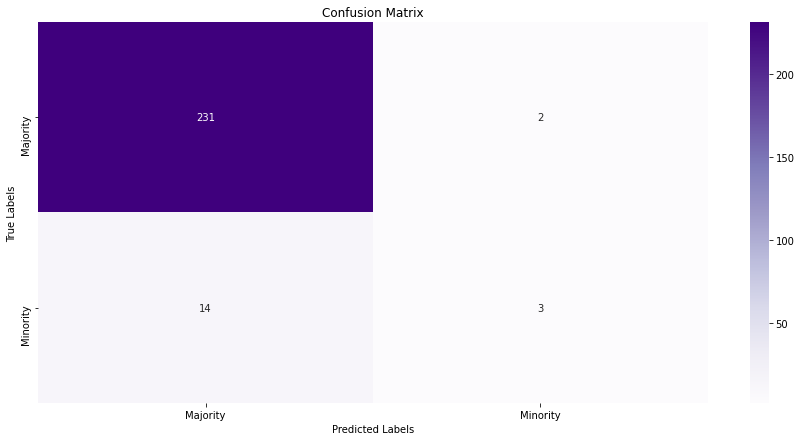

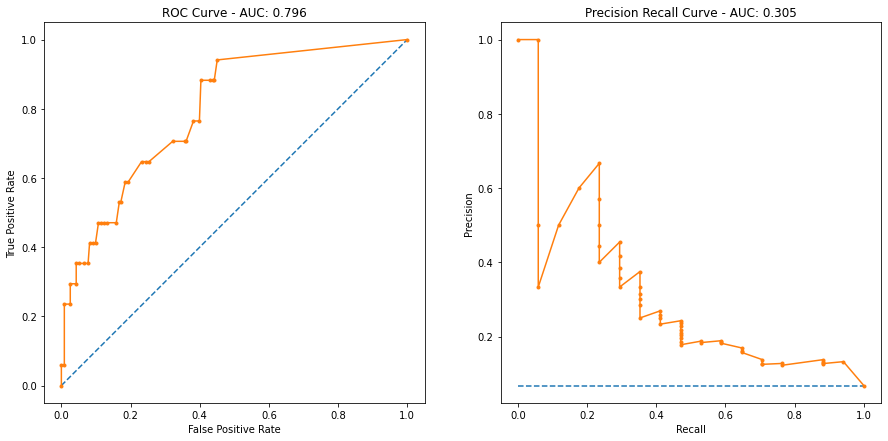

In [28]:
y_hat = best.predict_determine(X_test, y_test)
probs = best.predict_two_class(X_test, y_test)
con, cr, majority, minority = confusion('XGBoost', y_hat, y_test)
auc_rec, auc_pre_rec = plot_roc(classifier, y_test, y_hat, probs[:, 1])

In [29]:
results_df.loc['ImbalanceXGBoost'] = [*majority, *minority, auc_rec, auc_pre_rec]
results_df

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
RandomForest          0.942857  0.991416  ...  0.737314         0.320250
BalancedRandomForest  0.942857  0.991416  ...  0.785660         0.376677
WeightedRandomForest  0.939024  0.991416  ...  0.757258         0.302673
XGBoost               0.939024  0.991416  ...  0.853067         0.329810
WeightedXGBoost       0.940678  0.952790  ...  0.835521         0.309999
ImbalanceXGBoost      0.942857  0.991416  ...  0.796264         0.305123

[6 rows x 6 columns]

## Focal Loss - Keras
* Easy to implement custom loss for use in neural networks

In [30]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25 
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

# Define model
# model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer="adam") 

# Results

## Top Majority Precision

In [31]:
results_df.sort_values(('Majority', 'Precision'), ascending=False).head(3)

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
RandomForest          0.942857  0.991416  ...  0.737314         0.320250
BalancedRandomForest  0.942857  0.991416  ...  0.785660         0.376677
ImbalanceXGBoost      0.942857  0.991416  ...  0.796264         0.305123

[3 rows x 6 columns]

## Top Minority Recall

In [32]:
results_df.sort_values(('Minority', 'Recall'), ascending=False).head(3)

Majority            ...       AUC                 
                     Precision    Recall  ...       ROC Precision/Recall
RandomForest          0.942857  0.991416  ...  0.737314         0.320250
BalancedRandomForest  0.942857  0.991416  ...  0.785660         0.376677
WeightedXGBoost       0.940678  0.952790  ...  0.835521         0.309999

[3 rows x 6 columns]

## Top AUC

In [33]:
results_df.sort_values(('AUC', 'ROC'), ascending=False).head(3)

Majority            ...       AUC                 
                 Precision    Recall  ...       ROC Precision/Recall
XGBoost           0.939024  0.991416  ...  0.853067         0.329810
WeightedXGBoost   0.940678  0.952790  ...  0.835521         0.309999
ImbalanceXGBoost  0.942857  0.991416  ...  0.796264         0.305123

[3 rows x 6 columns]